<span style="font-size:2em;"> Hetrogeneous Devices</span>

<span style="font-size:1.5em;">The following codes demonstate an example QCloudSim with hetrogeneous quantum devices micmicing some of the IBM quantum devices. The setup includes a broker, a job generator and a QCloud. A broker is responsible for assigning the incoming jobs to resources with random assignment scheduling algorithm and rotational scheduling algorithm. The runtime of the simulation is limited by ```SIM_TIME.``` </span>

In [10]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from QJob import QJob
from JobLogger import JobLogger
from helperfun import *
from helperfun import INTERVAL
from datetime import datetime

In [11]:
class QCloud(object):

    """
    A quantum cloud or a QCloud has a number of unique devices. Each device has certain properties. 
    QCloud has only one property that is to execute the qjob (or quantum job) that the broker 
    assigns to a certain device. 

    """
    
    def __init__(self, env, num_qdevices):
        """ simulation environment (env) and quantum devices (simpy.PriorityResource)
            are declared at initialization. 
        
        """
        self.env = env
        self.num_qdevices = num_qdevices
        
        self.hummingbird65 = simpy.PriorityResource(env=env, capacity=1)
        self.condor1121 = simpy.PriorityResource(env=env, capacity=1)
        self.manhattan65 = simpy.PriorityResource(env=env, capacity=1)
        self.falcon27 = simpy.PriorityResource(env=env, capacity=1)
        self.montreal27 = simpy.PriorityResource(env=env, capacity=1)
        self.osprey433 = simpy.PriorityResource(env=env, capacity=1)
        self.heron133 = simpy.PriorityResource(env=env, capacity=1)
        self.eagle127 = simpy.PriorityResource(env=env, capacity=1)
        
        self.qdevicesList = [self.hummingbird65, self.condor1121, self.manhattan65,
                            self.falcon27, self.montreal27, self.osprey433,
                            self.heron133, self.eagle127]
        
    def execute(self, qjob):
        """ execute function take a quantum job (qjob) and process. """
        
        est_time = estimate_time(qjob)
        printLog(f"Job {qjob._id}\'s estimate time is {estimate_time(qjob):.2f}.", PrintLog)
        yield self.env.timeout(est_time)
        printLog(f"Job {qjob._id} processed with {random.randint(70, 99)}% of accuracy.", PrintLog)

In [12]:
class Broker(object):
    """ 
    Broker is responsible for assigning quantum jobs (qjobs) to an appropriate qdevice. 
    The goal of a broker is to utilize available quantum devices at QCloud. 
    
    """
    def __init__(self, env, prioritize):
        self.env = env
        self.prioritize = prioritize
        
    def schedule(self, qcloud, qjob, joblogger): 
        
        """
        Schedule layer is where all the qjobs arrive. Broker keeps qjobs in the central queue. 
        By default, broker provides a simple FIFO scheduling algorithm. The users can implement 
        their own scheduling algorithm. 
        
        """
        printLog(f'{qjob._id} arrives at the central queue at {self.env.now:.2f}.', PrintLog)
        arrival_time = self.env.now
        
        if not self.prioritize: 
            qjob.priority = 2
        
        ### scheduling policies
        rotate = False

        if rotate: 
            ## rotate machine        
            qdID = qjob._id%qcloud.num_qdevices
        else: 
            ## get a random machine
            qdID = random.randint(0, qcloud.num_qdevices-1)       
        
        with qcloud.qdevicesList[qdID].request(priority = qjob.priority) as request:
            yield request
            
            wait_time = self.env.now - arrival_time
            joblogger.wait_time.append(wait_time)
            
            printLog(f'{qjob._id} enters the qdevice at {self.env.now:.2f} with priority {qjob.priority}.', PrintLog)
            yield self.env.process(qcloud.execute(qjob))

            printLog(f'{qjob._id} leaves the qdevice at {self.env.now:.2f}.', PrintLog)
            joblogger.num_of_completed_jobs += 1

In [13]:
def setup(env, num_machines, joblogger):
    """Setup initializes a quantum cloud, a broker and job generator generating 
    jobs in approx. every INTERVAL minutes."""
    
    # initialize a quantum cloud
    qcloud = QCloud(env, num_machines)
    
    # initialize a broker
    # set prioritize = True for priority scheduling
    # False for FIFO scheduling
    
    broker = Broker(env = env, prioritize = False)
    
    # Create jobs while the simulation is running
    i = 0
    while True:
        yield env.timeout(incoming_job_interval())
        i += 1
        qjob = QJob(env, i)
        env.process(broker.schedule(qcloud, qjob, joblogger))   
    
        

In [14]:
data = {}

SIM_TIME = 10000
PrintLog = False # Detail Logs

# Setup and start the simulation
print(f'Simulation Started at {datetime.now()}')
sim_start_time = time.time()

for NUM_MAC in range(1, 9): 
    RANDOM_SEED = random.randint(2, 10000)
    random.seed(RANDOM_SEED)  # This helps to reproduce the results

    joblogger = JobLogger()

    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_MAC, joblogger))

    # Execute!
    env.run(until=SIM_TIME)
    data[NUM_MAC] = joblogger.wait_time

print(f'Simulation Ended at {datetime.now()}')
sim_end_time = time.time()
print(f'Elasped time - {sim_end_time-sim_start_time:.5f}')

Simulation Started at 2024-03-02 13:15:58.033548
Simulation Ended at 2024-03-02 13:15:58.954306
Elasped time - 0.92045


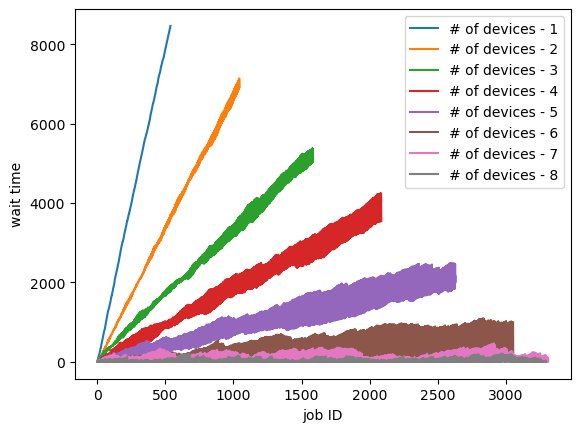

In [15]:
for i in range(1, 9): 
    plt.plot(data[i])

plt.legend(['# of devices - 1', 
            '# of devices - 2', '# of devices - 3', 
            '# of devices - 4', '# of devices - 5', 
            '# of devices - 6', '# of devices - 7', 
            '# of devices - 8', '# of devices - 9'])
plt.xlabel('job ID')
plt.ylabel('wait time')
plt.show()

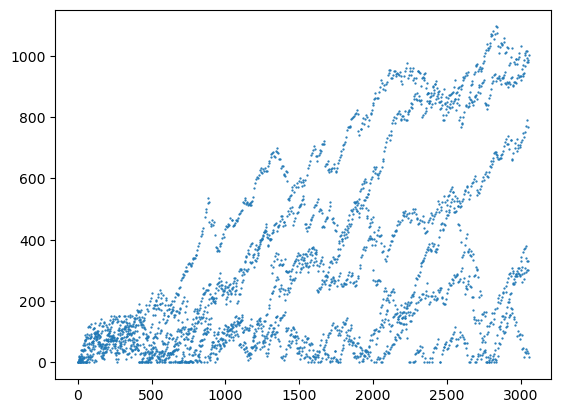

In [16]:
plt.plot(data[6], 'o', markersize = 0.6)